In [85]:
from __future__ import annotations
import jax
import jax.numpy as jnp

from jax.random import PRNGKey, multivariate_normal

import pyhf
import matplotlib.pyplot as plt
import numpy as np
from functools import partial

from typing import Callable, Any

pyhf.set_backend("jax")


def make_model(pars: jnp.array, bins=2) -> pyhf.Model:
    bounded_pars_upper = jnp.where(pars > 10.0, 10.0, pars)
    bounded_pars = jnp.where(bounded_pars_upper < -10.0, -10.0, bounded_pars_upper)
    if bins == 2:
        u1, d1 = bounded_pars
        u = jnp.array([u1, -u1])
        d = jnp.array([d1, -d1])

        sig = jnp.array([5, 11])
        nominal = jnp.array([50, 50])
        up = jnp.array([50, 50]) + u
        down = jnp.array([50, 50]) + d

    elif bins == 3:
        u1, u2, d1, d2 = bounded_pars
        u = jnp.array([u1, u2, -u1 - u2])
        d = jnp.array([d1, d2, -d1 - d2])

        sig = jnp.array([2, 5, 10])
        nominal = jnp.array([50, 50, 50])
        up = jnp.array([50, 50, 50]) + u
        down = jnp.array([50, 50, 50]) + d

    m = {
        "channels": [
            {
                "name": "singlechannel",
                "samples": [
                    {
                        "name": "signal",
                        "data": sig,
                        "modifiers": [
                            {"name": "mu", "type": "normfactor", "data": None}
                        ],
                    },
                    {
                        "name": "background",
                        "data": nominal,
                        "modifiers": [
                            {
                                "name": "bkguncrt",
                                "type": "histosys",
                                "data": {"hi_data": up, "lo_data": down},
                            }
                        ],
                    },
                ],
            }
        ]
    }
    return pyhf.Model(m, validate=False)


def fisher_info_covariance(
    bestfit_pars: jnp.array, m: pyhf.Model, observed_data: jnp.array
) -> jnp.array:
    return jnp.linalg.inv(
        jax.hessian(lambda lhood_pars: -m.logpdf(lhood_pars, observed_data)[0])(
            bestfit_pars
        )
    )


def gaussian_logpdf(
    bestfit_pars: jnp.array, data: jnp.array, cov: jnp.array
) -> jnp.array:
    return jax.scipy.stats.multivariate_normal.logpdf(data, bestfit_pars, cov).reshape(
        1
    )


def model_gaussianity(
    m: pyhf.Model,
    bestfit_pars: jnp.array,
    cov_approx: jnp.array,
    observed_data: jnp.array,
) -> jnp.array:
    # - compare the likelihood of the fitted model with a gaussian approximation that has the same MLE (fitted_pars)
    # - do this across a number of points in parspace (sampled from the gaussian approx) and take the mean squared diff
    # - centre the values wrt the best-fit vals to scale the differences
    gaussian_parspace_samples = multivariate_normal(
        key=PRNGKey(1), mean=bestfit_pars, cov=cov_approx, shape=(100,)
    )

    relative_nlls_model = jax.vmap(
        lambda pars, data: -(
            m.logpdf(pars, data)[0] - m.logpdf(bestfit_pars, data)[0]
        ),  # scale origin to bestfit pars
        in_axes=(0, None),
    )(gaussian_parspace_samples, observed_data)

    relative_nlls_gaussian = jax.vmap(
        lambda pars, data: -(
            gaussian_logpdf(pars, data, cov_approx)[0]
            - gaussian_logpdf(bestfit_pars, data, cov_approx)[0]
        ),  # data fixes the lhood shape
        in_axes=(0, None),
    )(gaussian_parspace_samples, bestfit_pars)

    diffs = relative_nlls_model - relative_nlls_gaussian
    return jnp.mean(diffs[jnp.isfinite(diffs)] ** 2, axis=0)


def metrics(
    bestfit_pars: jnp.array, m: pyhf.Model, observed_data: jnp.array
) -> jnp.array:
    cov_approx = fisher_info_covariance(bestfit_pars, m, observed_data)
    mu_idx, y_idx = m.config.par_order.index("mu"), m.config.par_order.index("bkguncrt")
    mu_uncert2 = cov_approx[mu_idx, mu_idx]
    pull_width_metric2 = (1 - cov_approx[y_idx, y_idx]) ** 2
    gaussianity = model_gaussianity(m, bestfit_pars, cov_approx, observed_data)
    cls_obs = pyhf.infer.hypotest(1.0, observed_data, m, init_pars=[0.0, 0.0])

    return dict(
        cls_obs=cls_obs,
        mu_uncert2=mu_uncert2,
        pull_width_metric2=pull_width_metric2,
        gaussianity=gaussianity,
    )


def pipeline(pars: jnp.array, observed_data: jnp.array) -> jnp.array:
    m = make_model(pars)
    data = jnp.concatenate((observed_data, jnp.array(m.config.auxdata)))
    mle_pars = pyhf.infer.mle.fit(data, m, init_pars=[0.0, 0.0])

    return jnp.array(list(metrics(mle_pars, m, data).values()))

In [75]:
import numpy as np

dense = 10
num_up, num_down = (dense, dense)

up_grid = np.linspace(-10, 0, num_up)
down_grid = np.linspace(-10, 0, num_down)

uv, dv = np.meshgrid(up_grid, down_grid)

In [76]:
obs_data = jnp.array([50.0, 50.0, 50.0])
pipe = partial(pipeline, observed_data=obs_data)

values = np.array([pipe(jnp.array(a)) for a in np.vstack([uv.ravel(), dv.ravel()]).T])

TypeError: pipeline() missing 1 required positional argument: 'observed_data'

NameError: name 'values' is not defined

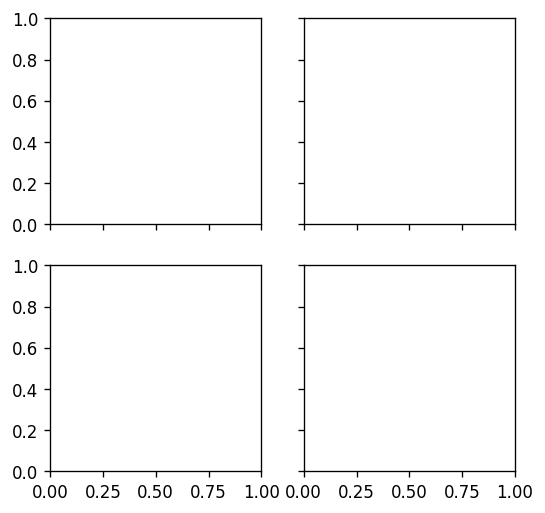

In [77]:
import matplotlib.pyplot as plt

plt.rc("figure", figsize=[5, 5], dpi=120, facecolor="w")

fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)

for i, (label, ax) in enumerate(
    zip(
        ["$CL_s$", r"$\sigma_{mu}^2$", r"$(1-\sigma_{\mathsf{np}})^2$", "gaussianity"],
        axs.ravel(),
    )
):
    p = ax.contourf(uv, dv, values[:, i].reshape((dense, dense)))
    plt.colorbar(p, ax=ax)
    ax.set_xlabel("u")
    ax.set_ylabel("d")
    ax.set_title(label)

plt.suptitle(
    "sig = [5,11], nom = [50,50]\nbkg_up = [nom+u,nom-u]\nbkg_down = [nom+d,nom-d]\n $|u|, |d|<10$"
)
plt.tight_layout()

In [23]:
mets = {
    metric: val
    for val, metric in zip(vals.T, ["cls", "mu_err^2", "[1-np_err]^2", "gaussianity"])
}

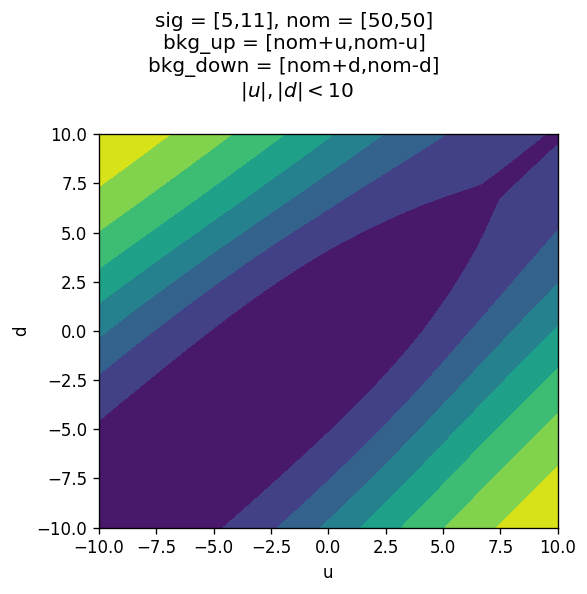

In [127]:
plt.rc("figure", figsize=[5, 5], dpi=120, facecolor="w")

values[:, 1] /= 2
values[:, 2] /= 4
values[:, 3] /= 200


p = plt.contourf(uv, dv, values.sum(axis=1).reshape((dense, dense)))

plt.xlabel("u")
plt.ylabel("d")

plt.suptitle(
    "sig = [5,11], nom = [50,50]\nbkg_up = [nom+u,nom-u]\nbkg_down = [nom+d,nom-d]\n $|u|, |d|<10$"
)
plt.tight_layout()

In [61]:
def evaluate_logpdf(
    logpdf: Callable[..., list[float]],
    data: np.ndarray,
    reference: np.ndarray,
    pdfargs: list[Any] = [],
) -> tuple[np.ndarray]:
    grid = xi, yi = np.mgrid[-4:4:51j, -2:2:51j]
    X = np.swapaxes(grid, 0, -1).reshape(-1, 2)
    r = jax.vmap(logpdf, in_axes=(0, *[None for i in range(len(pdfargs) + 1)]))(
        X, data, *pdfargs
    )
    zi = -2 * (r[:, 0].reshape(51, 51).T - logpdf(reference, data, *pdfargs))
    return xi, yi, zi

In [ ]:
plt.rc("figure", figsize=[5, 5], dpi=120, facecolor="w")

fig, ax = plt.subplots()
from matplotlib.lines import Line2D

custom_lines = [
    Line2D([0], [0], color="C9", lw=2),
    Line2D([0], [0], color="C1", lw=2),
]


levels = [1, 2, 4, 8]
pars = up, down = jnp.array([-5, -10])
m = make_model(pars)
data = np.concatenate((np.ones(2) * 50.0, m.config.auxdata))
bestfit = pyhf.infer.mle.fit(data, m, init_pars=[0, 0])
model_eval = evaluate_logpdf(m.logpdf, data, bestfit)

cov_approx = fisher_info_covariance(bestfit, m, data)
gaussian_eval = evaluate_logpdf(gaussian_logpdf, bestfit, bestfit, [cov_approx])

ax.contourf(*model_eval, levels=levels)  # , colors="C9")
ax.contour(*gaussian_eval, levels=levels, colors="C1")
ax.set_xlabel(m.config.par_order[0])
ax.set_ylabel(m.config.par_order[1])

ax.legend(custom_lines, [f"model(u={up}, d={down})", "gaussian approx"])

In [43]:
cov_approx.shape[-2:]

(2, 2)

In [56]:
[i for i in range(0)]

[]

In [80]:
Ts = 1 / (44 * 1000)
(1 / 880) / Ts

50.0